In [2]:
import os
import time

import numpy as np
import tqdm
import torch
import matplotlib.pyplot as plt

from quadrotor_diffusion.utils.nn.training import Trainer
from quadrotor_diffusion.models.diffusion_wrapper import DiffusionWrapper, SamplerType
from quadrotor_diffusion.models.vae_wrapper import VAE_Wrapper
from quadrotor_diffusion.utils.dataset.normalizer import Normalizer
from quadrotor_diffusion.utils.nn.args import TrainerArgs
from quadrotor_diffusion.utils.quad_logging import iprint as print
from quadrotor_diffusion.utils.plotting import plot_states, add_gates_to_course, add_trajectory_to_course, course_base_plot
from quadrotor_diffusion.utils.file import get_checkpoint_file
from quadrotor_diffusion.utils.plotting import plot_states
from quadrotor_diffusion.planner import plan, plan_traj_frame, cudnn_benchmark, ScoringMethod

%load_ext autoreload
%autoreload 2

In [3]:
# COURSE = "../data/courses/triangle/12"
EXPERIMENT = 253

model: DiffusionWrapper = None
ema: DiffusionWrapper = None
normalizer: Normalizer = None
trainer_args: TrainerArgs = None

chkpt = get_checkpoint_file("../logs/training", EXPERIMENT)
diff, ema, normalizer, trainer_args = Trainer.load(chkpt)
model = diff
model = model.cuda()
print(f"Loaded {chkpt}")
print(f"Using {normalizer}")

vae_experiment: int = 249
chkpt = get_checkpoint_file("../logs/training", vae_experiment)
vae_wrapper: VAE_Wrapper = None
vae_wrapper, _, _, _ = Trainer.load(chkpt, get_ema=False)
vae_wrapper = vae_wrapper.cuda()

LATENT_MODEL = True

if LATENT_MODEL:
    vae_downsample = 2 ** (len(vae_wrapper.args[1].channel_mults) - 1)

    model.encoder = vae_wrapper.encode
    model.decoder = vae_wrapper.decode
else:
    vae_downsample = 1

[ 805912170 ] Loaded ../logs/training/253.DiffusionWrapper.Apr.25_08:45_PM/checkpoints/epoch_399_loss_0.0778
[ 805912170 ] Using NoNormalizer


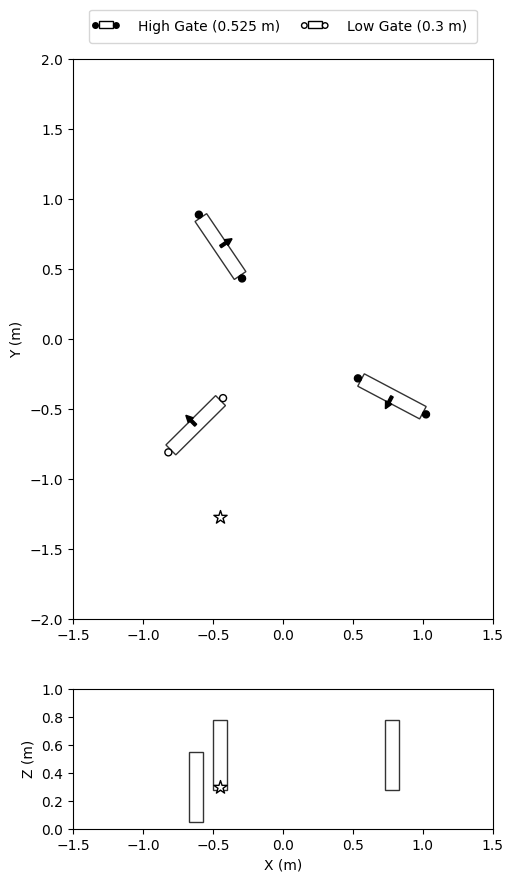

In [98]:
COURSE = "../data/courses/eval/212"
course = np.load(os.path.join(COURSE, "course.npy"))

_, axs = course_base_plot()
add_gates_to_course(course, axs, has_end=False)

In [ ]:
B = 250
w = 0.2
sampler = (SamplerType.DDIM, 1)
cudnn_benchmark(B, model, vae_downsample, "cuda", sampler, w=w)

[ planner ] Warming with cudnn benchmark...
[ planner ] Finished cudnn benchmark


[ 2336131259 ] Considered trajectories from 0


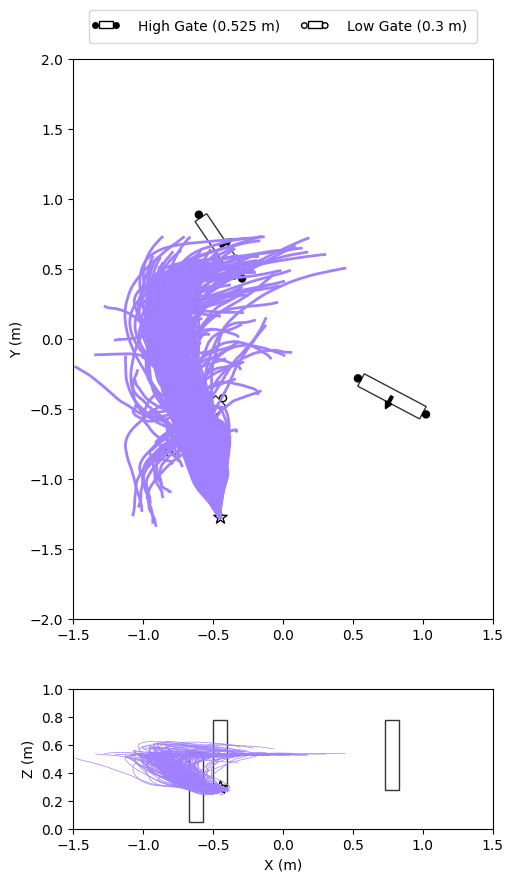

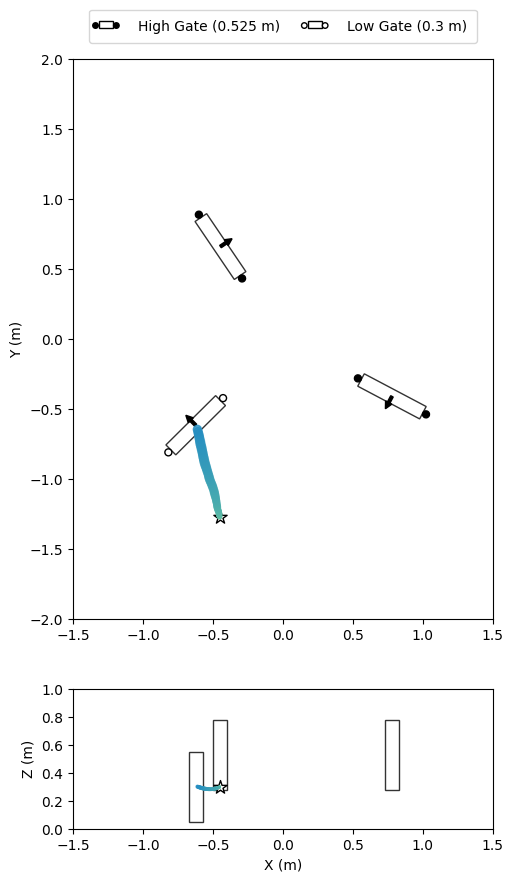

[ 2336131259 ] Considered trajectories from 1


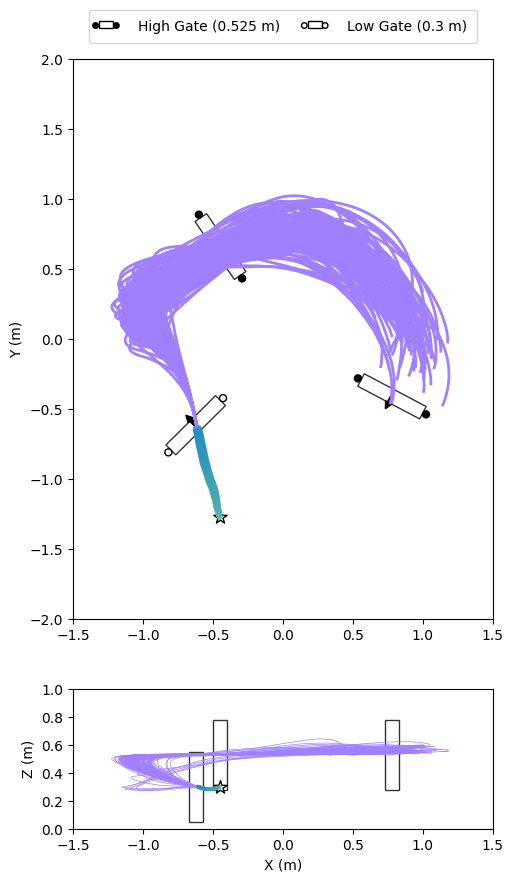

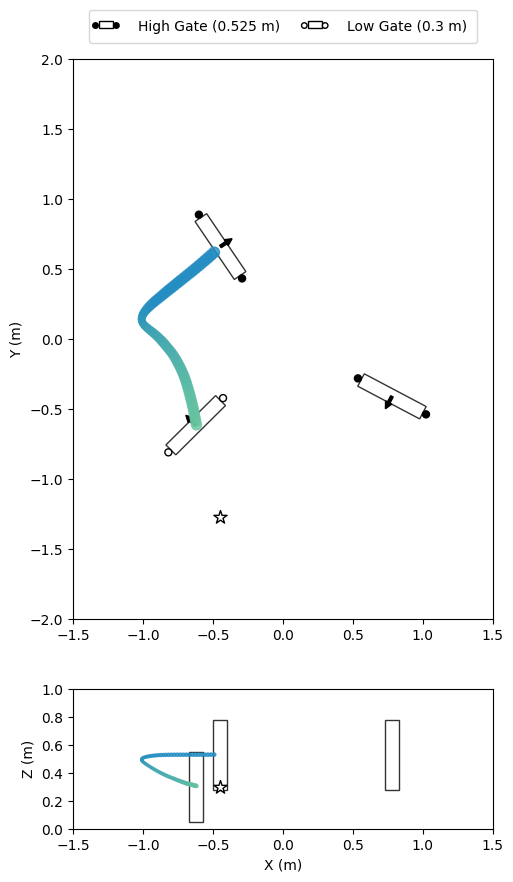

[ 2336131259 ] Considered trajectories from 2


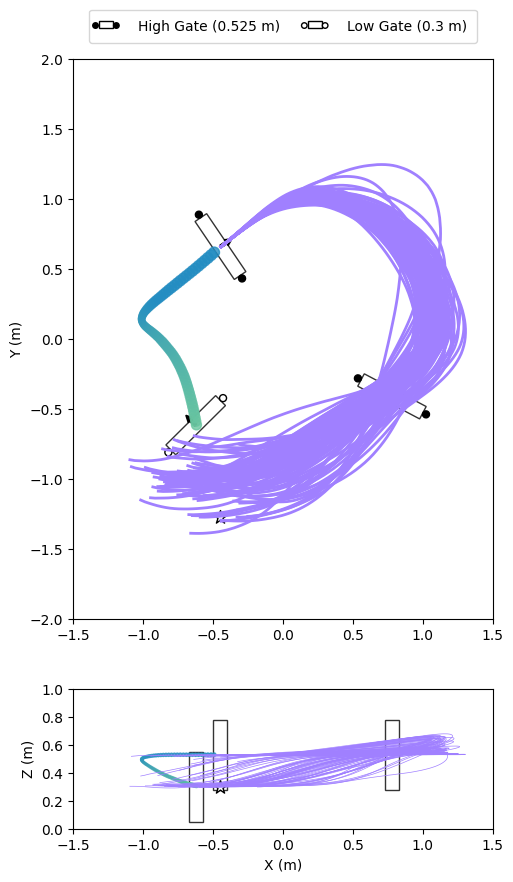

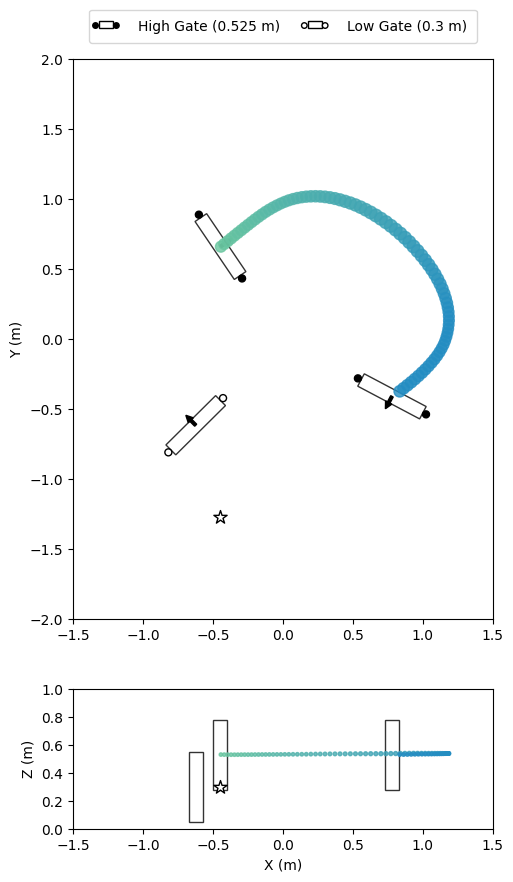

[ 2336131259 ] Considered trajectories from 3


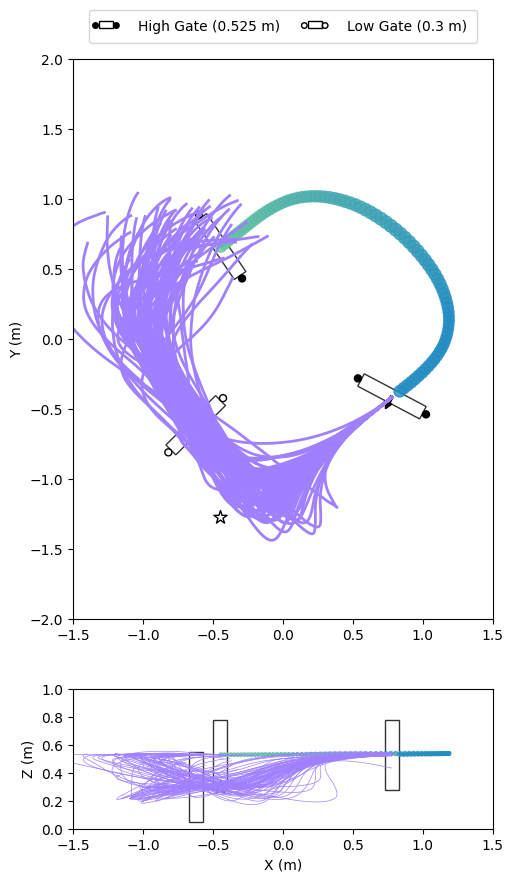

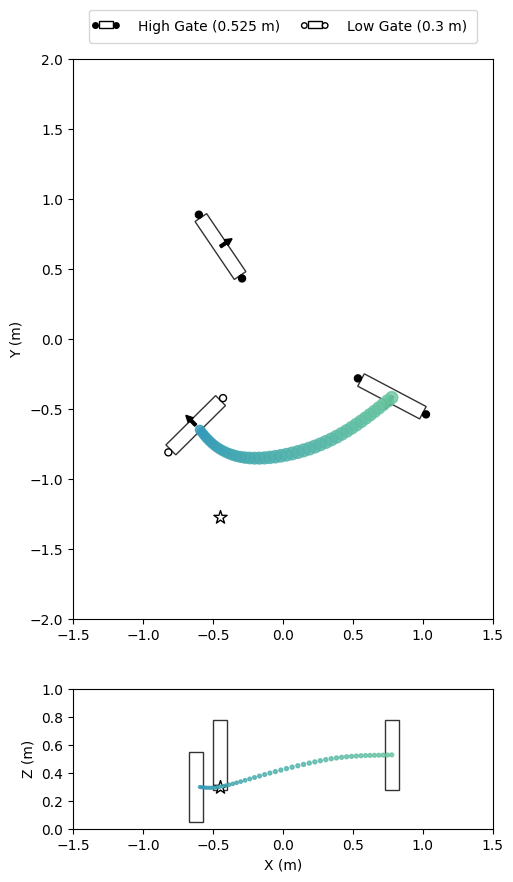

[ 2336131259 ] Considered trajectories from 1


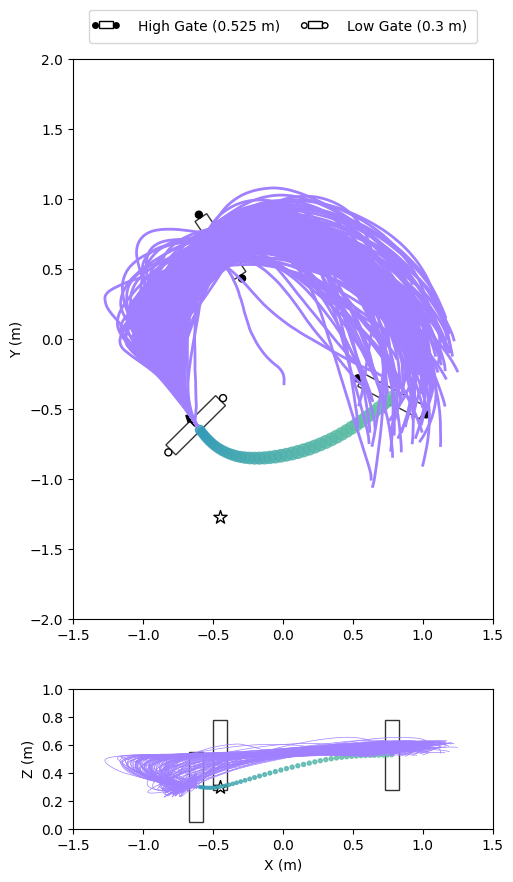

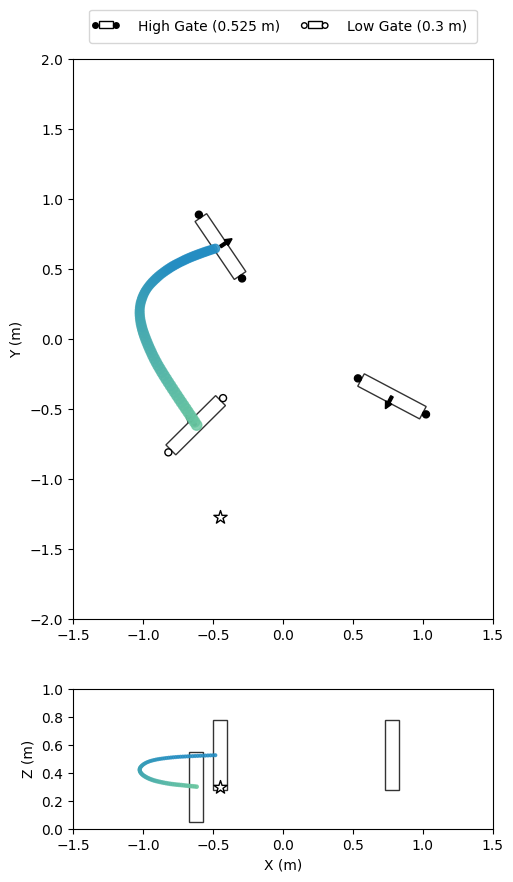

[ 2336131259 ] Considered trajectories from 2


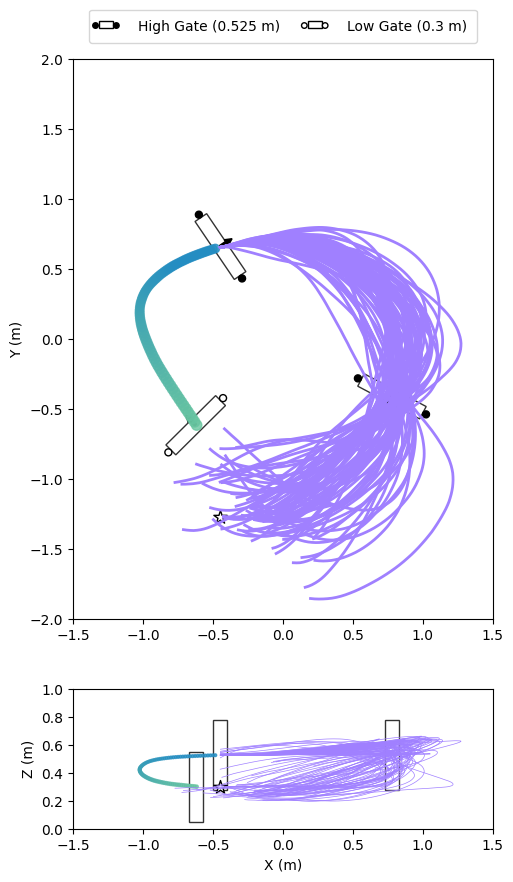

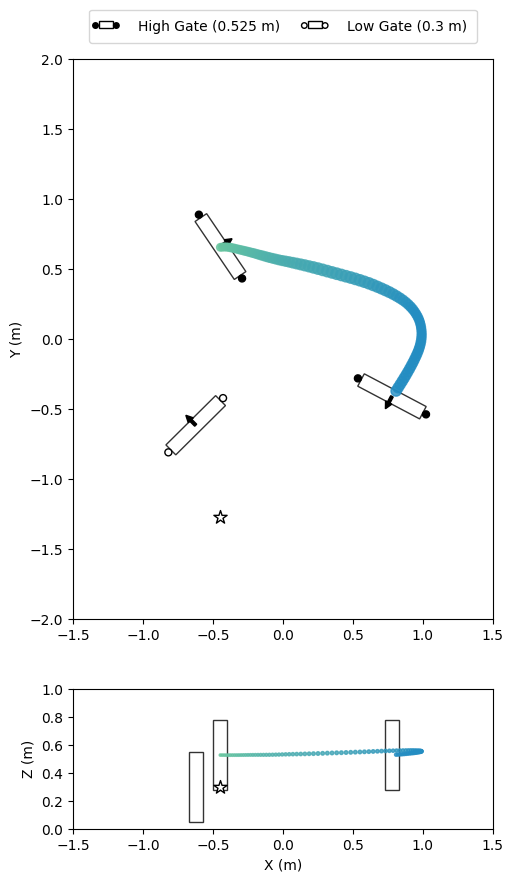

[ 2336131259 ] Considered trajectories from 3


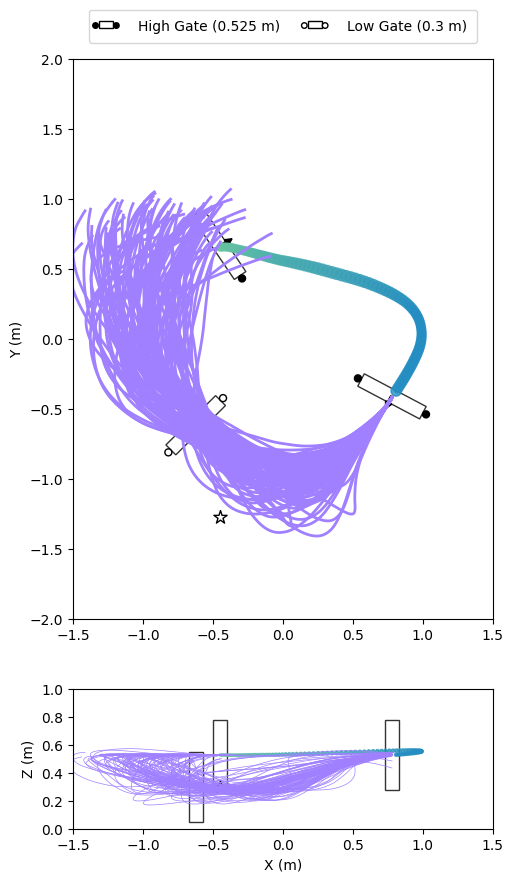

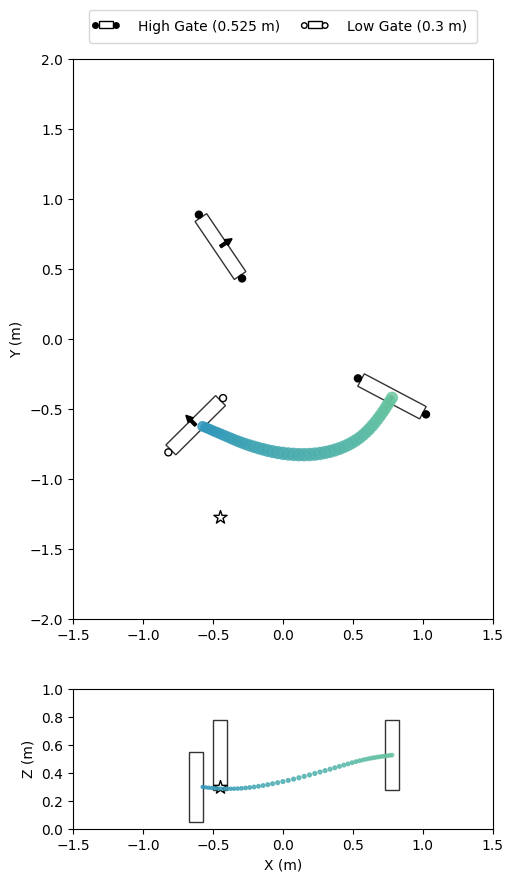

In [99]:
current_traj = None

gate_idx = 0

computation_times = []
trajectory_times = []
trajectories = []

LAPS = 2
gates_per_lap = course.shape[0] - 1
iterations = gates_per_lap * LAPS + 1
for i in range(iterations):
    # Provide the full course because the 0th position will be used for creating the local conditioning
    global_context = course
    if current_traj is not None:
        global_context = np.vstack((course[gate_idx + 1:], course[1:gate_idx]))    
    
    s = time.time()
    next_traj, candidates = plan_traj_frame(
        B,
        global_context,
        sampler,
        w,
        ScoringMethod.CENTER,
        model,
        vae_downsample,
        "cuda",
        current_traj=current_traj,
        ignore_filter_step=False
    )
    trajectories.append(next_traj)
    
    computation_times.append(
        time.time() - s
    )
    trajectory_times.append(
        next_traj[0].shape[0] / 30
    )
    
    print(f"Considered trajectories from {gate_idx}")
    _, axs = course_base_plot()
    add_gates_to_course(course, axs, has_end=False)
    if current_traj:
        add_trajectory_to_course(axs, current_traj[0])
    for traj in candidates:
        add_trajectory_to_course(axs, traj.cpu().numpy(), reference=True)
    plt.show()
    plt.close()
    
    _, axs = course_base_plot()
    add_gates_to_course(course, axs, has_end=False)
    add_trajectory_to_course(axs, next_traj[0])
    plt.show()
    plt.close()
    
    gate_idx += 1
    current_traj = next_traj
    
    # Looped back around to previous gate
    if gate_idx == len(course):
        gate_idx = 1
    

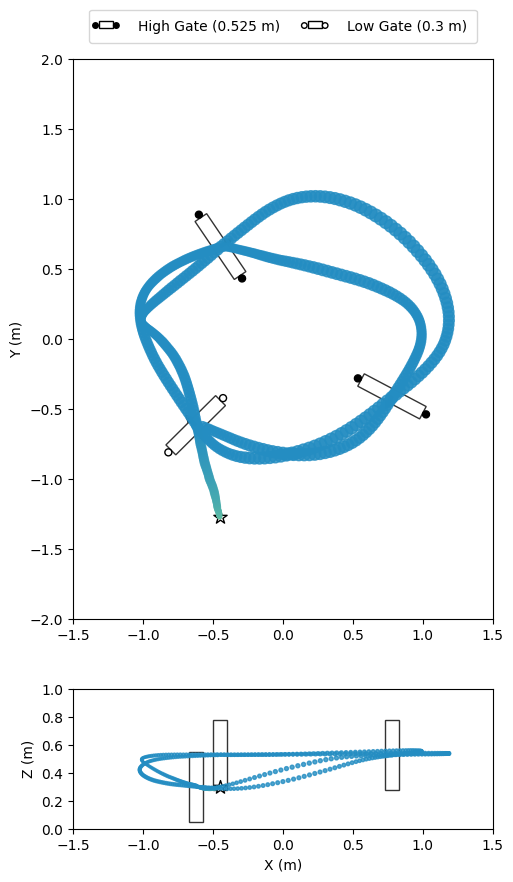

In [100]:
states = [np.vstack([t[idx] for t in trajectories]) for idx in range(3)]
_, axs = course_base_plot()
add_gates_to_course(course, axs, has_end=False)
add_trajectory_to_course(axs, states[0])

In [420]:
print(sum(trajectory_times))

[ 2770381850 ] 18.566666666666666


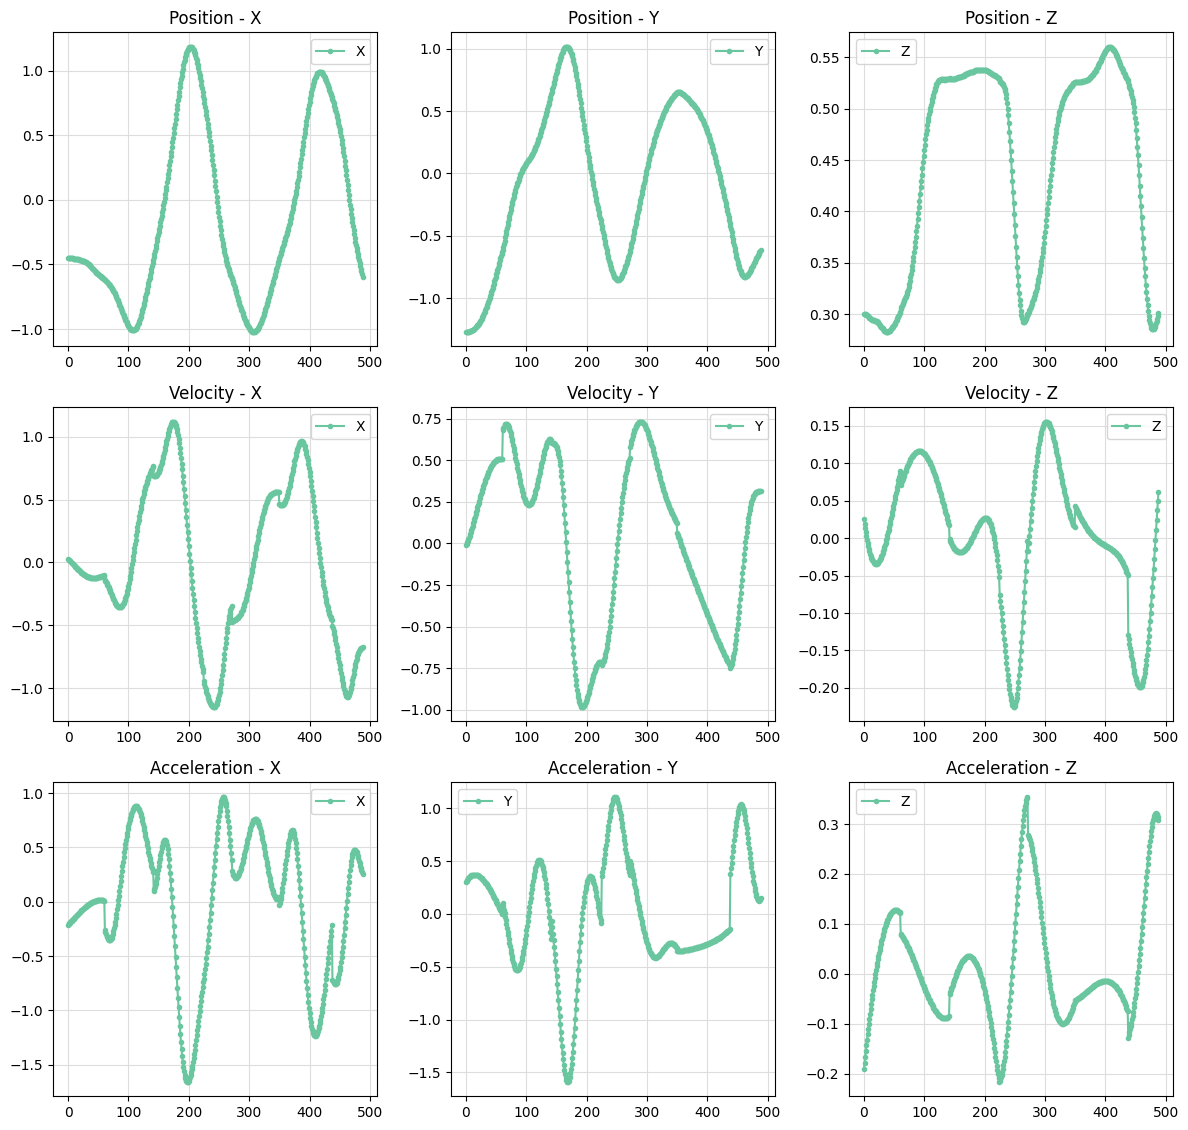

In [101]:
plot_states(*states)

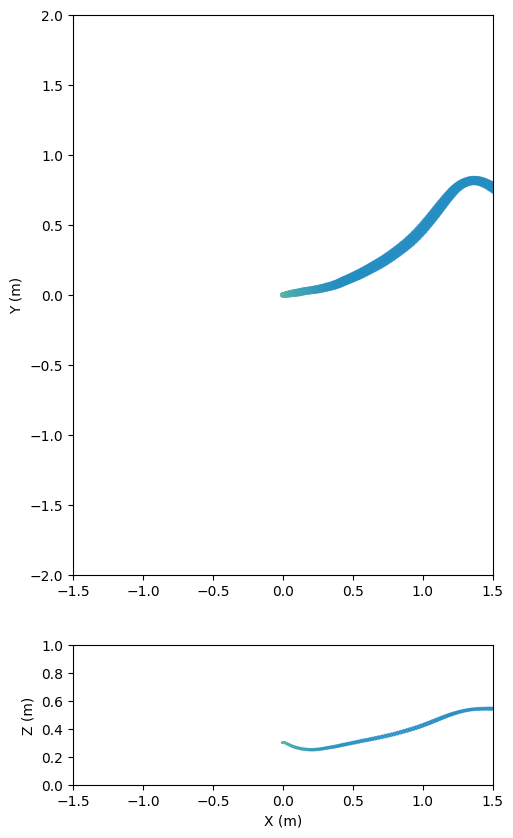

In [26]:
t = 10
eps = torch.randn_like(mu)
mu_t = torch.sqrt(model.alpha_bar[t]) * mu + torch.sqrt(1 - model.alpha_bar[t]) * eps
traj = model.decoder(mu_t.unsqueeze(0)).squeeze(0)

_, axs = course_base_plot()
add_trajectory_to_course(axs, traj.cpu())

In [9]:
print(computation_times[1:])
print(trajectory_times)

[ 87713355 ] [1.125990390777588, 1.13161039352417, 1.2663841247558594, 1.1133599281311035, 1.1153924465179443, 1.1151793003082275, 1.1131820678710938, 1.1198837757110596]
[ 87713355 ] [1.8, 2.4, 2.1, 2.2, 2.1, 1.9666666666666666, 2.1, 2.3, 2.1333333333333333]


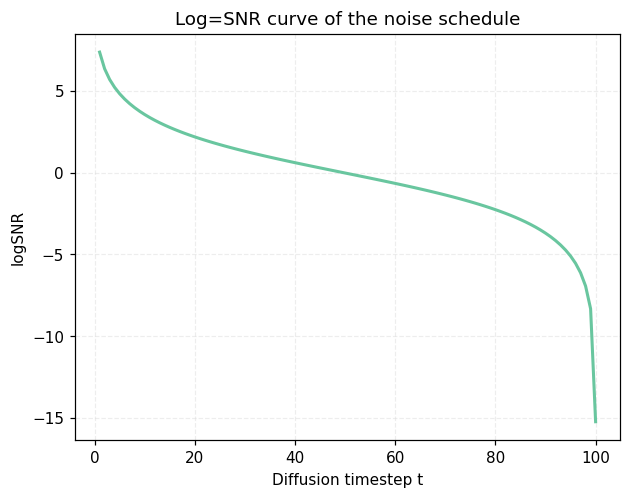

In [11]:
alpha_bar = model.alpha_bar.cpu()

snr = alpha_bar / (1.0 - alpha_bar)
log_snr = torch.log(snr)

steps = torch.arange(1, len(alpha_bar) + 1)

plt.figure(dpi=110)
plt.plot(steps, log_snr.numpy(), linewidth=2)
plt.xlabel("Diffusion timestep t")
plt.ylabel("logSNR")
plt.title("Log=SNR curve of the noise schedule")
plt.grid(True, linestyle="--", alpha=0.5)

# Optional: put t = 0 (highest signal) on the right by reversing the x‑axis
# plt.gca().invert_xaxis()

plt.show()

In [12]:
mus, _ = model.encoder(candidates)

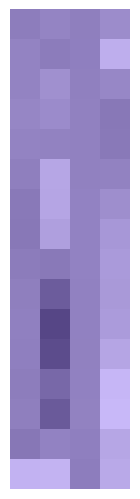

In [13]:
import matplotlib
from matplotlib.colors import LinearSegmentedColormap, Normalize, to_rgb


for mu_idx, mu in enumerate(mus):
    colors = matplotlib.rcParams['axes.prop_cycle'].by_key()['color'][:3]
    base_color = colors[2]

    # Convert to RGB and create light/dark variants
    rgb = np.array(to_rgb(base_color))
    light_rgb = 1 - 0.5 * (1 - rgb)  # Move halfway to white
    dark_rgb = 0.5 * rgb             # Move halfway to black

    # Create the custom colormap
    cmap = LinearSegmentedColormap.from_list("custom_shade", [light_rgb, dark_rgb])

    # Normalize as before
    norm = Normalize(vmin=-1.5, vmax=1.5)

    # Plot
    plt.imshow(mu.cpu().squeeze(0).numpy(), cmap=cmap, norm=norm)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    # plt.savefig(f"{mu_idx}.pdf")

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting
import numpy as np
import matplotlib

idx =0
for trajectory in candidates[:4]:
    trajectory = trajectory.cpu().numpy()
    
    # Custom colormap from default matplotlib colors
    colors = matplotlib.rcParams['axes.prop_cycle'].by_key()['color'][:3]
    primary_colors = [colors[0], colors[1]]
    colormap = LinearSegmentedColormap.from_list('custom_map', primary_colors)
    norm = Normalize(vmin=0, vmax=1)  # since we're using step/128

    # Create the plot
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    fig.patch.set_alpha(0)  # Transparent background
    ax.axis('off')

    # Compute color values based on step progress
    steps = np.linspace(0, 1, len(trajectory))
    colors = colormap(norm(steps))

    # Plot segment by segment
    for i in range(len(trajectory) - 1):
        xs, ys, zs = trajectory[i:i+2, 0], trajectory[i:i+2, 1], trajectory[i:i+2, 2]
        ax.plot(xs, ys, zs, color=colors[i], linewidth=8)

    # Remove padding
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    ax.set_position([0, 0, 1, 1])

    # Save as clean SVG
    # plt.savefig(f'trajectory{idx}.svg', transparent=True, format='svg', bbox_inches='tight', pad_inches=0)
    plt.close()
    idx += 1


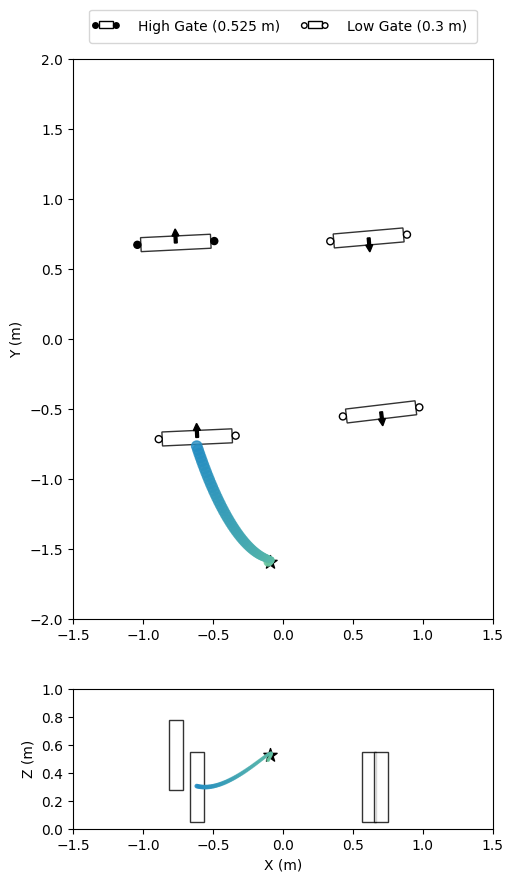

In [13]:
TRAJ = 0

_, axs = course_base_plot()
add_gates_to_course(course, axs, has_end=False)
add_trajectory_to_course(axs, trajectories[TRAJ][0])
plt.show()
plt.close()

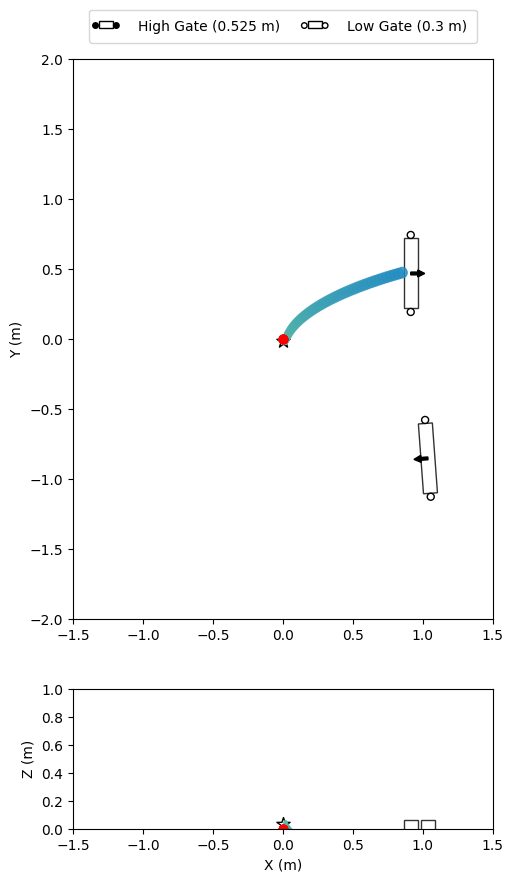

In [15]:

from copy import deepcopy
from scipy.spatial.transform import Rotation as R

def compute_yaw(traj, first=True):
    i1 = 0 if first else -2
    i2 = 1 if first else -1
    
    delta = traj[i2] - traj[i1]
    yaw = np.arctan2(delta[1], delta[0])
    return yaw

yaw = compute_yaw(trajectories[TRAJ][0])
if TRAJ == 0:
    yaw = course[1][3] + np.pi/2

rotation = R.from_euler('z', -yaw).as_matrix()

translation = trajectories[TRAJ][0][0].copy()

course_adjusted = deepcopy(course)
course_adjusted[:, :3] = (course[:, :3] - translation) @ rotation.T
course_adjusted[:, 3] -= yaw
course_adjusted[:, 3] = np.arctan2(np.sin(course_adjusted[:, 3]), np.cos(course_adjusted[:, 3]))
traj_rotated = (trajectories[TRAJ][0] - translation) @ rotation.T

conditioning_points = trajectories[TRAJ - 1][0][-6:]
if TRAJ == 0:
    conditioning_points = np.tile(trajectories[TRAJ][0][0], ((6, 1)))
conditioning_points = (conditioning_points - translation) @ rotation.T

_, axs = course_base_plot()
add_gates_to_course(course_adjusted, axs, has_end=False)
add_trajectory_to_course(axs, traj_rotated)
axs[0].scatter(conditioning_points[:, 0], conditioning_points[:, 1], color='red')
axs[1].scatter(conditioning_points[:, 0], conditioning_points[:, 2], color='red')
plt.show()

plt.close()

In [96]:
i = 5

print(compute_yaw(trajectories[i][0], first=False))
print(compute_yaw(trajectories[i+1][0], first=True))


[ 2022142217 ] 1.1496079493299844
[ 2022142217 ] 1.3471209653471916


In [153]:
from quadrotor_diffusion.utils.dataset.dataset import DiffusionDataset
from quadrotor_diffusion.utils.dataset.normalizer import NoNormalizer

dataset = DiffusionDataset("../data", traj_len=128, normalizer=NoNormalizer(), folder="diffusion5")
print(len(dataset))

[ 3589144299 ] 12


[ dataset ] ../data/courses/diffusion5/0_1.pkl
[ 579896575 ] tensor([[-1.1383e-01, -1.5797e-04,  2.7776e-01],
        [-9.4947e-02, -7.8081e-05,  2.8143e-01],
        [-7.6009e-02, -3.2623e-05,  2.8512e-01],
        [-5.7030e-02, -1.0374e-05,  2.8883e-01],
        [-3.8029e-02, -1.9105e-06,  2.9255e-01],
        [-1.9016e-02,  7.9456e-18,  2.9627e-01]])
[ 579896575 ] tensor([[ 0.8849,  1.1153,  0.5250,  0.1882],
        [-0.7519,  1.4182,  0.3000,  2.6586],
        [ 5.0000,  5.0000,  5.0000,  5.0000],
        [ 5.0000,  5.0000,  5.0000,  5.0000]])


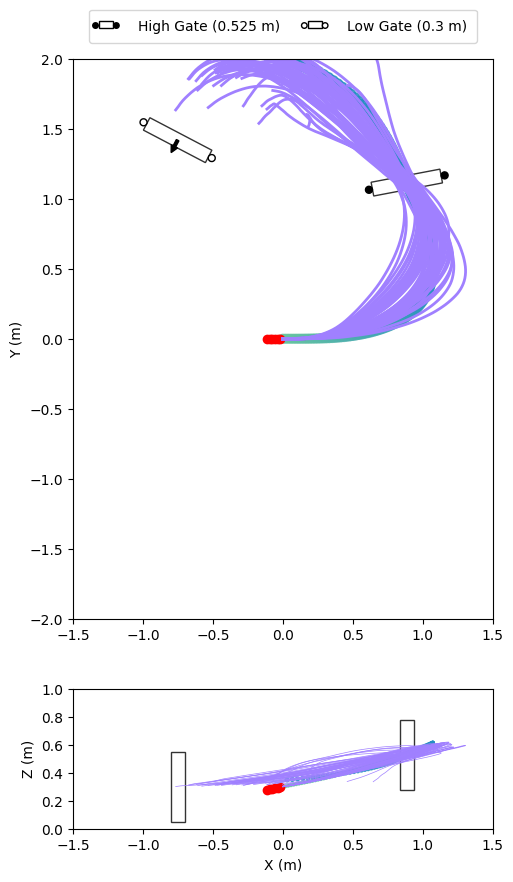

In [388]:
d = dataset[10]
    
course = d["global_conditioning"]
context = d["local_conditioning"]
traj = d["x_0"]

_, axs = course_base_plot()
add_gates_to_course(course, axs, has_end=False, has_start=False)
add_trajectory_to_course(axs, traj)

axs[0].scatter(context[:, 0], context[:, 1], color='red')
axs[1].scatter(context[:, 0], context[:, 2], color='red')

print(context)
print(course)


context = context.unsqueeze(0).repeat((50, 1, 1)).cuda()
course = course.unsqueeze(0).repeat((50, 1, 1)).cuda()
traj = model.sample(
    50, 
    128,
    "cuda",
    context,
    course,
    (SamplerType.DDIM, 1),
    decoder_downsample=8,
    w=0.
)
for t in traj:
    t = t.cpu()
    add_trajectory_to_course(axs, t, reference=True)

plt.show()
plt.close()

[ 3411546375 ] -0.7873099
[ 3411546375 ] [-0.07397163  0.93114763]


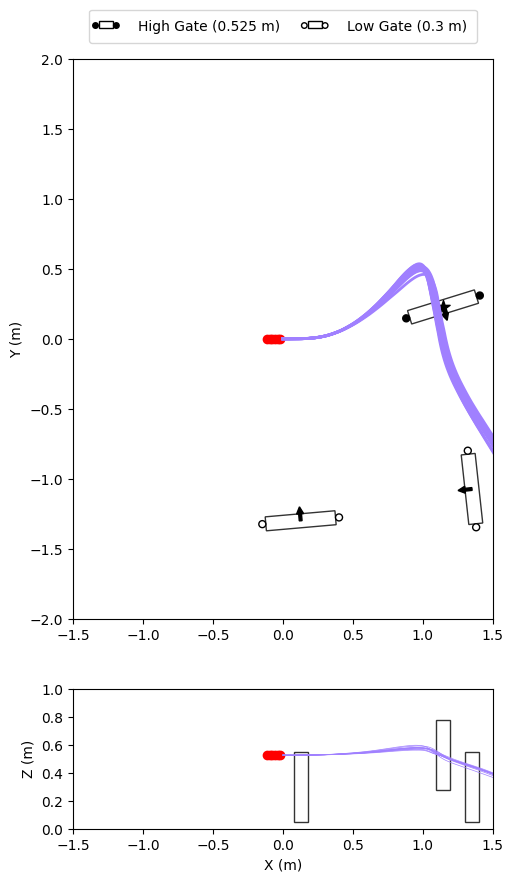

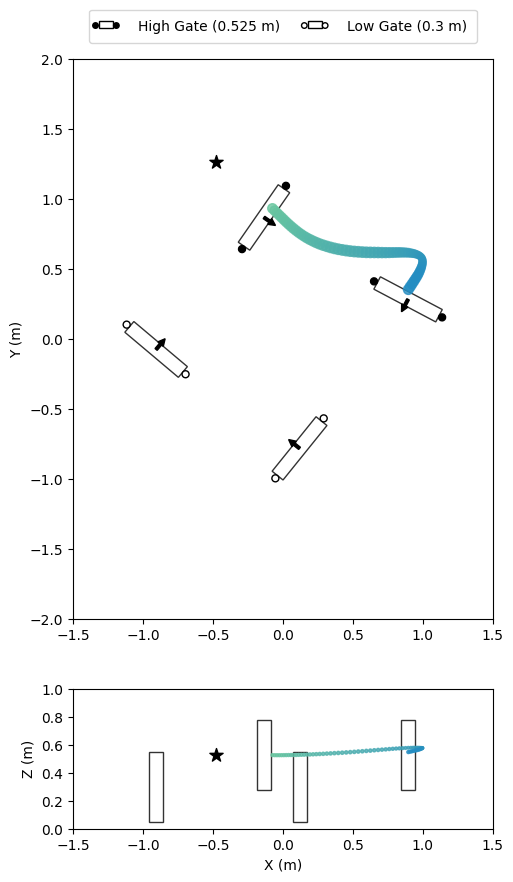

In [394]:
from scipy.spatial.transform import Rotation as R

COURSE = "../data/courses/eval/118"
course = np.load(os.path.join(COURSE, "course.npy"))

gate_idx = 1

gates = np.vstack((course[gate_idx+1:], course[1:gate_idx]))

if gate_idx == 0:
    yaw = gates[0][3] + np.pi/2
    trans_xy = course[0][:2]
else:
    p2 = t[-1]
    p1 = t[-2]
    delta = p2 - p1
    velocity = delta * 30
    
    x_0_projected = p2 + velocity * 1/30
    
    yaw = np.arctan2(delta[1], delta[0])
    print(yaw)
    trans_xy = x_0_projected[:2]
    print(trans_xy)


rotation = R.from_euler('z', -yaw).as_matrix()
rot_xy = rotation[:2, :2]

gates[:, :2] = (gates[:, :2] - trans_xy) @ rot_xy.T
gates[:, 3] -= yaw
gates[:, 3] = np.arctan2(np.sin(gates[:, 3]), np.cos(gates[:, 3]))

if gate_idx == 0:
    context = np.tile(course[0][:3], (6, 1)).copy()
else:
    context = t[-6:].copy()

context[:, :2] = (context[:, :2] - trans_xy) @ rot_xy.T

_, axs = course_base_plot()
add_gates_to_course(gates, axs, has_end=False, has_start=False)
axs[0].scatter(context[:, 0], context[:, 1], color='red')
axs[1].scatter(context[:, 0], context[:, 2], color='red')

context = torch.tensor(context, dtype=torch.float32, device="cuda").unsqueeze(0).repeat((10, 1, 1))

null_tokens = np.tile(np.array(5 * np.ones((1, 4))), (4 - len(gates), 1))
gates = np.vstack((gates, null_tokens))
gates = torch.tensor(gates, dtype=torch.float32, device="cuda").unsqueeze(0).repeat((10, 1, 1))


traj = model.sample(
    10, 
    128,
    "cuda",
    context,
    gates,
    (SamplerType.DDIM, 1),
    decoder_downsample=8,
    w=0.
)
for t in traj:
    t = t.cpu()
    add_trajectory_to_course(axs, t, reference=True)

goal = gates[0, 0, :3].cpu()
idx = np.argmin(np.linalg.norm(t - goal, axis=-1))
t = t[:idx].numpy()
plt.show()
plt.close()

_, axs = course_base_plot()
add_gates_to_course(course, axs, has_end=False)

t[:, :2] = (t[:, :2] @ rot_xy) + trans_xy
add_trajectory_to_course(axs, t)


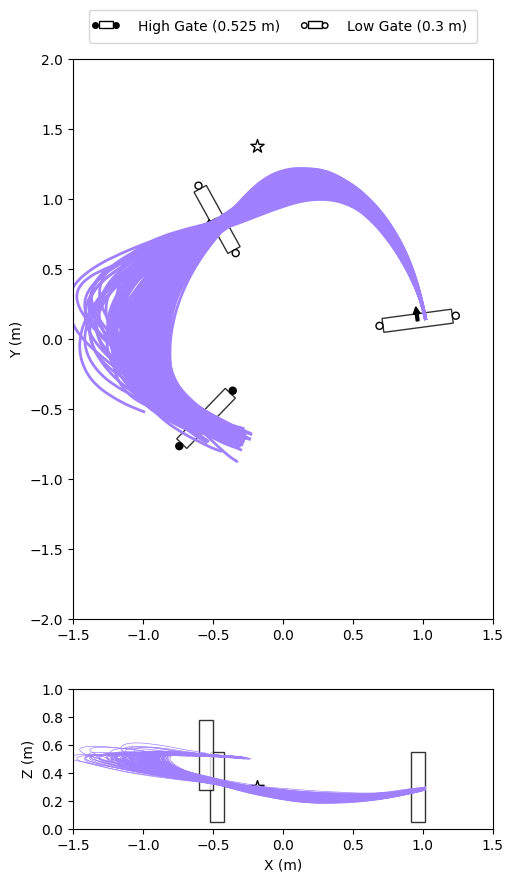

In [410]:
COURSE = "../data/courses/triangle/8"
course = np.load(os.path.join(COURSE, "course.npy"))

_, axs = course_base_plot()
add_gates_to_course(course, axs, has_end=False)

gate_idx = 3
if gate_idx == 0:
    current_traj = None

global_context = course
if gate_idx > 0:
    global_context = np.vstack((course[gate_idx + 1:], course[1:gate_idx]))    

next_traj, candidates = plan_traj_frame(
    B,
    global_context,
    sampler,
    w,
    ScoringMethod.FAST,
    model,
    vae_downsample,
    "cuda",
    current_traj=current_traj,
    ignore_filter_step=False
)
for traj in candidates:
    add_trajectory_to_course(axs, traj.cpu().numpy(), reference=True)

current_traj = next_traj